In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

%matplotlib inline

In [136]:
# read the two data files
users = pd.read_csv('takehome_users.csv', encoding='latin1', index_col=0)
eng = pd.read_csv('takehome_user_engagement.csv')

# convert users time stamp columns to datetimes
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = \
    pd.to_datetime(users['last_session_creation_time'], unit='s')

#convert engagement time stamp column to datetime
eng['time_stamp'] = pd.to_datetime(eng['time_stamp'])

## Calculate if a user adopted or not

In [137]:
# set the default adopted value to zero
users['adopted'] = 0
# get total number of visits by user_id
total_eng = eng.groupby('user_id').count()
# create a timedelta object for 7 days
td = timedelta(days=7)

# loop through all users
for uid in eng['user_id'].unique():
    # can disregard any user with less than 3 visits
    if total_eng.loc[uid, 'visited'] < 3:
        continue
    else:
        # create tmp dataframe for just the current user
        tmp = eng[eng['user_id'] == uid].copy()
        # loop through the time stamps
        for ts in tmp['time_stamp']:
            # create mask to check visits between ts and ts + td
            mask = (tmp['time_stamp'] >= ts) & (tmp['time_stamp'] <= (ts + td))
            # check the sum of visits in the masked time frame
            if tmp[mask].sum()['visited'] >= 3:
                # if sum is 3 or more, user has adopted
                users.loc[uid, 'adopted'] = 1
                # break out of the ts loop if user adopted
                break

## Check adoption rates by different features

In [144]:
adopted_mean = users['adopted'].mean()

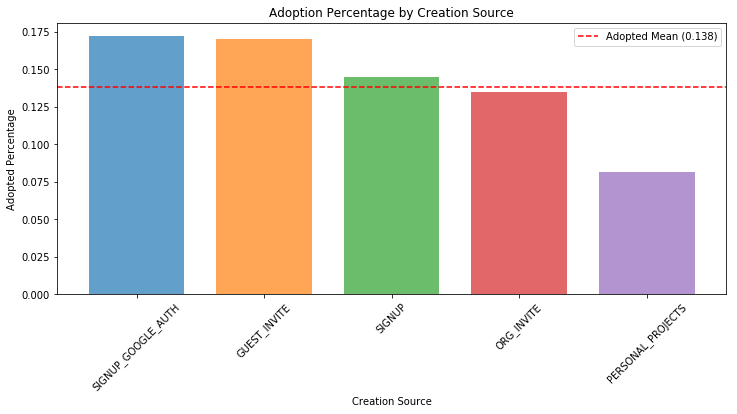

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

_ = users.groupby('creation_source')['adopted'] \
         .mean() \
         .sort_values(ascending=False) \
         .plot(kind='bar', alpha=0.7, width=0.75)

_ = ax.axhline(adopted_mean, color='red', linestyle='--')
_ = ax.set(xlabel='Creation Source', ylabel='Adopted Percentage',
           title='Adoption Percentage by Creation Source')
_ = ax.legend(['Adopted Mean ({})'.format(adopted_mean)])
_ = plt.xticks(rotation=45)

Users who created their account using Google authentication are the most likely to adopt the product, followed closely by users that were invited by a guest. Users who were invited to join another user's personal workspace are the least likely to adopt the product.

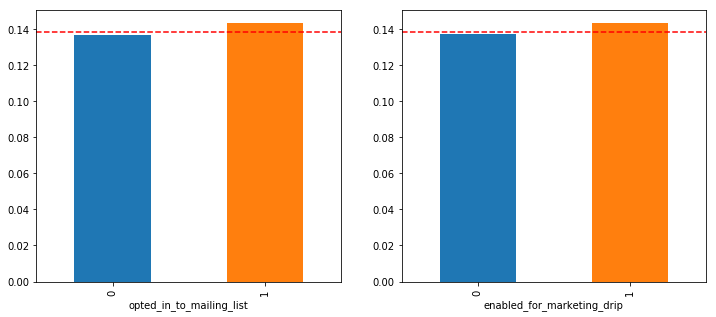

In [184]:
# fig, axes = plt.subplots(3, 1, figsize=(6, 12))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

_ = users.groupby('opted_in_to_mailing_list')['adopted'] \
        .mean().plot(kind='bar', ax=ax1)
_ = users.groupby('enabled_for_marketing_drip')['adopted'] \
        .mean().plot(kind='bar', ax=ax2)
    
_ = ax1.axhline(adopted_mean, color='red', linestyle='--')
_ = ax2.axhline(adopted_mean, color='red', linestyle='--')

In [185]:
display(users.groupby(['opted_in_to_mailing_list', 
               'enabled_for_marketing_drip'])['adopted'].mean())

opted_in_to_mailing_list  enabled_for_marketing_drip
0                         0                             0.136279
                          1                             0.135556
1                         0                             0.141041
                          1                             0.146051
Name: adopted, dtype: float64

Users that opted in to the mailing list are generally more likely to adopt than users that did not. Users that recieve both the mailing list and the marketing drip are the most likely to adopt the product (14.61%). Interestingly, users that were enabled for the marketing drip without opting in to the mailing list are the least likely to adopt (13.56%). This is slightly lower than users that recieve neither the mailing list or marketing drip (13.63%).

The reason for this is that the marketing drip is (probably) enabled by default. If the user cares enough to modify their settings, they are more likely to be invested in the product.

In [195]:
most_freq_domains = list(users.email_domain.value_counts()[:6].index)

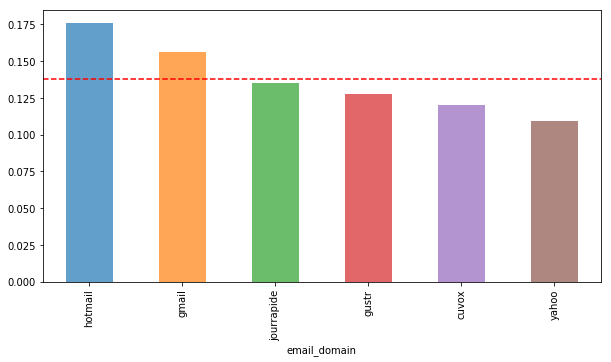

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

_ = users[users['email_domain'].isin(most_freq_domains)] \
        .groupby('email_domain')['adopted'].mean() \
        .sort_values(ascending=False).plot(kind='bar', alpha=0.7, ax=ax)
        
_ = ax.axhline(adopted_mean, color='red', linestyle='--')

Users with hotmail and gmail accounts are more likely to adopt the product than any other domain.

Users that were invited were more likely to adopt the product.

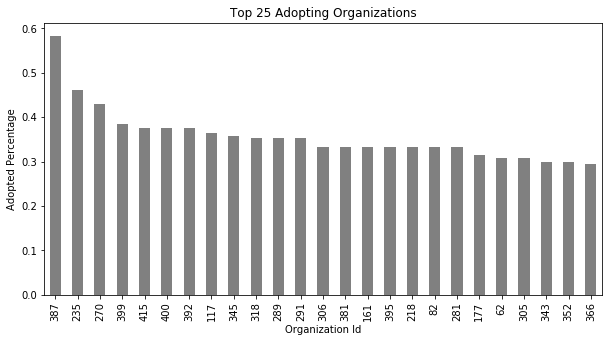

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

_ = users.groupby('org_id')['adopted'].mean().sort_values(ascending=False)[:25] \
        .plot(kind='bar', ax=ax, color='gray')

_ = ax.set(xlabel='Organization Id', ylabel='Adopted Percentage',
           title='Top 25 Adopting Organizations')